In [2]:
import numpy as np
import pandas as pd
import polars as pl
import datetime
import polars_ols as pls
from matplotlib import pyplot as plt
from mpl_bsic import apply_bsic_logo, apply_bsic_style, export_figure


In [3]:
bond_data = pl.read_parquet('../../data/final_data/data_with_signals_all.pq')
bond_data.head()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_12mo_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null,null,0.006591,0.000514,null,null,null,null,NaN,NaN,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_shortdur""",0.017731,0.004472,0.000579,3.964976,0.002296,-0.000011,0.000918,7,0.356791,-0.000224,null,null,null,null,null,null,null,0.006529,0.000918,null,null,null,null,NaN,NaN,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_shortdur""",0.014568,0.004472,0.000579,3.257695,0.001887,0.000097,0.001135,7,0.356791,0.002127,null,null,null,null,null,null,null,0.005614,0.001135,null,null,null,null,NaN,NaN,null,null,null


In [4]:
class Backtester:
    def __init__(
        self,
        bond_data: pl.DataFrame,
        half_life: int,
        formation_end_date: datetime.date,
        avg_bid_ask: float,
        benchmark_path: str,
        return_col: str = 'bond_ret_t+1'
    ) -> None:
        
        self.bond_data = bond_data.sort(['cusip', 'date'])   # DataFrame with time series of alpha estimates for each bond   
        self.signals = [f'{signal_name}_signal_value' for signal_name in ['equity_momentum', 'carry', 'credit_momentum', 'esp']]
        self.return_col = return_col
        
        self.formation_end_date = formation_end_date
        self.avg_bid_ask = avg_bid_ask
        self.half_life = half_life
        self.alpha = 1 - np.exp(-np.log(2) / self.half_life)   
        self.benchmark_path = benchmark_path
        
        self.dates = bond_data.select('date').sort('date').unique()
        
    def _load_benchmark(self, returns_index: pd.Index): 
        benchmark = pd.read_excel(self.benchmark_path)
        benchmark = benchmark.rename(columns={column: column.lower() for column in benchmark.columns})
        benchmark = benchmark.set_index('date').reindex(returns_index)
        benchmark['benchmark_cumret'] = benchmark['change'].add(1).cumprod()
        
        return benchmark
        
    def _compute_partial_returns(self, to_date: datetime.date):
        data = self.bond_data.filter(pl.col('date') < to_date)
        signals = self.signals
        signals_cols = [pl.col(signal) for signal in signals]
        
        partial_returns = data.select(
            pl.col('date'),
            pl
            .col('residual_return_t+1')
            .least_squares.ols(*signals_cols, add_intercept=False, mode='coefficients', null_policy='drop')
            .over('date')
        ).unnest('coefficients')
        
        return partial_returns
    
    def compute_signal_weights(self) -> pl.DataFrame:
        # initialize variables
        alpha = self.alpha
        signals = self.signals
        formation_date = self.formation_end_date
        print(f'using alpha={alpha}')
        
        # compute partial returns during the formation period
        partial_returns_formation_period = self._compute_partial_returns(formation_date)
        
        # calculate partial return volatility
        dates = self.bond_data.filter(pl.col('date') >= formation_date).get_column('date').unique()
        v_0 = partial_returns_formation_period.drop('date').std() # compute volatility at time 0 as a starting point
        
        pr_volatilities = np.zeros((len(dates), len(self.signals)))
        signal_weights = np.zeros((len(dates), len(self.signals)))
                                  
        pr_volatilities[0] = v_0.to_numpy()[0]  # initialize with the volatility from the formation period
        # TODO SUBSTITUTE WITH FAMA-MACBETH LOADINGS
        partial_returns_t_0 = partial_returns_formation_period.drop('date')[-1].to_numpy()[0]
        signal_weights[0] = partial_returns_t_0 / np.sum(partial_returns_t_0)
        
        j = 0
        for i in range(1,len(dates)):
            j += 1
            if j % 50 == 0: 
                print(f'j={j}, {j/len(dates)*100:.2f}%')
            date = dates[i]
            
            partial_rets = self._compute_partial_returns(date)
            r_t = partial_rets.drop('date')[-1].to_numpy()[0]
            
            pr_volatilities[i] = (1-alpha) * pr_volatilities[i-1] + alpha * np.power(r_t, 2)
            signal_weights[i] = (1-alpha) * signal_weights[i-1] + alpha * r_t / pr_volatilities[i]
            
        signal_weights = signal_weights / signal_weights.sum(axis=1).reshape(-1,1)
        signal_weights = pl.DataFrame(signal_weights).rename({f'column_{i}': signals[i] for i in range(len(signals))}).with_columns(
            date=dates
        )
        
        # rename columns to weights
        signal_weights = signal_weights.rename({col: col.replace('value', 'weight') for col in signals})
            
        return signal_weights
       
    def compute_alpha_estimates(self): 
        bond_data, formation_date, signals = self.bond_data, self.formation_end_date ,self.signals
        signal_weights = self.compute_signal_weights()
        
        df = bond_data.filter(pl.col('date') >= formation_date).join(
            signal_weights,
            how='left',
            on='date'
        )
        
        condition = pl.any_horizontal(pl.col(*signals).is_null())
        
        df = df.with_columns(
            composite_signal=pl.when(condition).then(None).otherwise(pl.col('carry_signal_weight') * pl.col('carry_signal_value') + pl.col('credit_momentum_signal_weight') * pl.col('credit_momentum_signal_value') + pl.col('esp_signal_weight') * pl.col('esp_signal_value') + pl.col('equity_momentum_signal_weight') * pl.col('equity_momentum_signal_value')
            )
        )
        
        return df
    
    def compute_quantiles(self, df: pl.DataFrame, col: str, n_quantiles: int):
        """Divide the cols in quantiles based on the bucket groups"""
        quantile_col_name = f'{col}_quantile'
        
        # create the bins and labels to be used in qcut
        bins = np.linspace(0,1,n_quantiles+1)[1:]
        labels = [str(i+1) for i in range(n_quantiles+1)]
        
        data = []
        for group in df.select('date').unique().iter_rows():
            date = group[0]
            
            group_data = df.filter((pl.col('date') == date) & (pl.col(col).is_not_null())).select('cusip', 'date', col)
    
            # if the DataFrame is emtpy just continue, otherwise qcut will throw an error
            if group_data.shape[0] == 0:
                continue
            
            group_data = group_data.with_columns(
                pl.col(col).qcut(bins,labels=labels, allow_duplicates=True).alias(quantile_col_name)
            )
                
            data.append(group_data)
            
        print('... done!')
        
        quantiles = pl.concat(data, how='vertical')
        quantiles = quantiles.with_columns(
            pl.col(quantile_col_name).cast(int).alias(quantile_col_name)
        )
        return df.join(quantiles.drop('bucket'), how='left', on=['date', 'cusip'])
    
    def get_mvo_weights(self, cusips: list[str], date: datetime.date):
        bonds_data = self.bond_data.filter((pl.col('cusip').is_in(cusips)) & (pl.col('date') <= date))
        
        return bonds_data.with_columns(
            weight=(1/pl.col('cusip').n_unique())
        ).select('cusip', 'weight')
    
    def run(
        self,
    ):
        bond_data, formation_end_date, avg_bid_ask = self.bond_data, self.formation_end_date, self.avg_bid_ask
        return_col = self.return_col
        alpha_estimates = self.compute_alpha_estimates()
        quantiles = self.compute_quantiles(alpha_estimates, 'composite_signal', 10)
        
        new_cusips= np.zeros(alpha_estimates.shape[0])
        past_cusips = []
        i=0
        
        portfolio_weights = pd.DataFrame(
            columns=quantiles.get_column('cusip').unique())
        
        for date in quantiles.sort('date').select('date').unique().iter_rows(): 
            date = date[0]
            data = quantiles.filter(pl.col('date') == date)
            bonds = data.filter(pl.col('composite_signal_quantile') == 10)
                
            bonds = bonds.sort('composite_signal_quantile')
            
            # pick the top 25 bonds
            cusips = bonds[:25].get_column('cusip').unique().to_list()
            new_cusips[i]  = len(set(cusips)-set(past_cusips))
            past_cusips = cusips
            i = i+1
            
            weights = self.get_mvo_weights(cusips, date)
            
            for row in weights.iter_rows(named=True):
                cusip = row['cusip']
                weight = row['weight']
                
                portfolio_weights.loc[date, cusip] = weight
                
        # compute portfolio asset_returns
        asset_returns = bond_data.select('cusip', 'date', return_col).to_pandas()
        asset_returns = asset_returns.pivot(index='date', columns='cusip', values=return_col).reindex(portfolio_weights.columns, axis=1)
           
        portfolio_returns = (asset_returns * portfolio_weights).sum(axis=1)
        
        portfolio_returns = portfolio_returns[portfolio_returns.index >= pd.to_datetime(formation_end_date)]
        
        # compute returns post transaction costs
        post_tc_cumulative_return = np.zeros(len(portfolio_returns))
        post_tc_cumulative_return[0] = 1 

        for i in range (1, len(portfolio_returns)):
            post_tc_cumulative_return[i] = post_tc_cumulative_return[i - 1] * (1 - new_cusips[i - 1] / 25 * avg_bid_ask) * (1 + portfolio_returns[i - 1])
            
        # group everything into a DataFrame
        strategy_returns = pd.DataFrame(portfolio_returns, columns=['ex_tc_ret'])
        
        # add benchmark returns
        benchmark = self._load_benchmark(strategy_returns.index)
        strategy_returns = strategy_returns.join(benchmark['benchmark_cumret'], how='left')
        
        strategy_returns['ex_tc_cumret'] = strategy_returns['ex_tc_ret'].add(1).cumprod()
        strategy_returns['post_tc_cumret'] = post_tc_cumulative_return
        
        return strategy_returns

In [17]:
FORMATION_END_DATE = datetime.date(2006,1,1)
BID_ASK_SPREAD = 0.004
HALF_LIFE = 12
BENCHMARK_PATH = '../../data/indices/barclays_aggregate_global.xlsx'
RETURN_COL = 'bond_ret_t+1'
bt = Backtester(bond_data, HALF_LIFE, FORMATION_END_DATE, BID_ASK_SPREAD, BENCHMARK_PATH, RETURN_COL)

returns = bt.run()

using alpha=0.05612568731830647
j=50, 24.88%
j=100, 49.75%
j=150, 74.63%
j=200, 99.50%
... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
C:\Users\andre\AppData\Local\Temp\ipykernel_123784\3480013615.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  post_tc_cumulative_return[i] = post_tc_cumulative_return[i - 1] * (1 - new_cusips[i - 1] / 25 * avg_bid_ask) * (1 + portfolio_returns[i - 1])


In [6]:
returns.head()

,ex_tc_ret,benchmark_cumret,ex_tc_cumret,post_tc_cumret
2006-01-31,0.010932,1.000057,1.010932,1.000000
2006-02-28,0.010903,1.003376,1.021954,1.006888
2006-03-31,-0.001207,0.993530,1.020721,1.014609
2006-04-30,0.005368,0.991729,1.026199,1.010304
2006-05-31,-0.002733,0.990671,1.023395,1.013452


In [16]:
returns_hedging_irr = returns

fonts already added so will not add again
fonts already added so will not add again


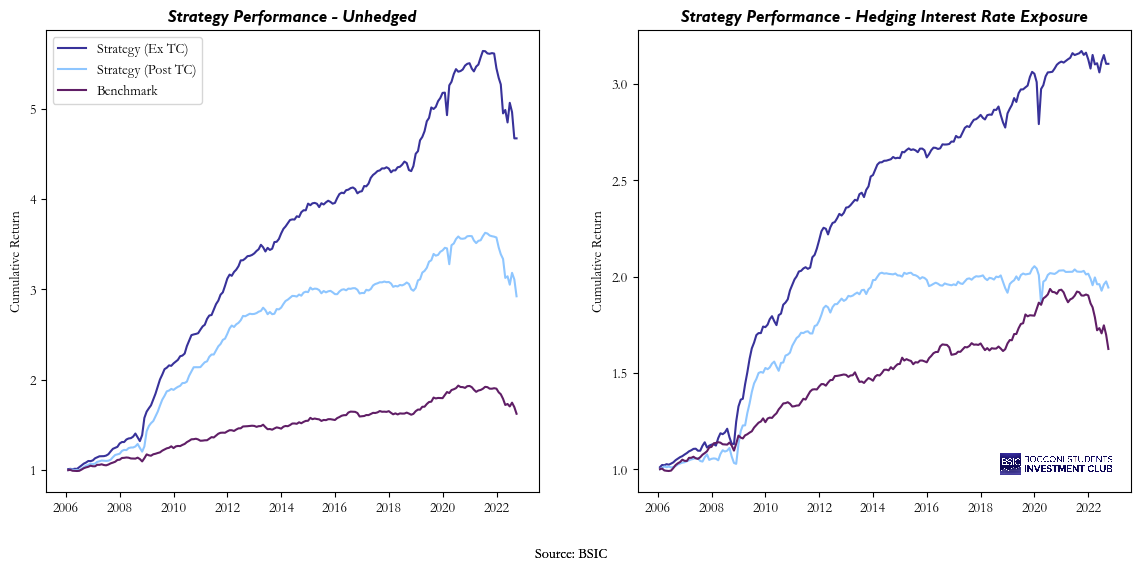

In [30]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
plt.style.use('default')

ax1, ax2 = axs
apply_bsic_style(fig, ax1)

ax1.plot(returns.index, returns['ex_tc_cumret'], label='Strategy (Ex TC)')
ax1.plot(returns.index, returns['post_tc_cumret'], label='Strategy (Post TC)')
ax1.plot(returns.index, returns['benchmark_cumret'], label='Benchmark')
ax1.set_ylabel('Cumulative Return')

ax1.legend()
apply_bsic_logo(fig, ax2, location='bottom right')
ax1.set_title('Strategy Performance - Unhedged')

ax2.plot(returns_hedging_irr.index, returns_hedging_irr['ex_tc_cumret'], label='Strategy (Ex TC)')
ax2.plot(returns_hedging_irr.index, returns_hedging_irr['post_tc_cumret'], label='Strategy (Post TC)')
ax2.plot(returns_hedging_irr.index, returns_hedging_irr['benchmark_cumret'], label='Benchmark')
ax2.set_title('Strategy Performance - Hedging Interest Rate Exposure')
ax2.set_ylabel('Cumulative Return')
apply_bsic_style(fig, ax2)


In [31]:
export_figure(fig, '../../exports/strategy_pnl_final')

In [9]:
def rolling_sharpe(strategy_returns: pd.DataFrame): 
    rfr = pd.read_csv('../../data/indices/treasuries_1mo.csv')
    rfr = rfr.rename(columns={col: col.lower() for col in rfr.columns})
    rfr.index = pd.to_datetime(rfr['date'])
    rfr.drop('date', axis=1, inplace=True)
    rfr.columns = ['rfr']
    rfr = rfr.resample('ME').last()
    strategy_returns = strategy_returns.join(rfr.resample('D').last(), how='left')
    
    sharpe = strategy_returns[['post_tc_cumret', 'rfr']]
    sharpe['strategy_ret'] = sharpe['post_tc_cumret'].pct_change()
    sharpe['rfr'] = (sharpe['rfr'] / 100 + 1) ** (1 / 12) - 1
    sharpe['rolling_sharpe'] = (sharpe['strategy_ret'].rolling(24).mean() - sharpe['rfr'].rolling(24).mean()) / sharpe['strategy_ret'].rolling(24).std()
    sharpe['rolling_sharpe_ann'] = sharpe['rolling_sharpe'] * np.sqrt(12)
    
    sharpe_tot = sharpe['post_tc_cumret'].mean() - sharpe['rfr'].mean() / sharpe['post_tc_cumret'].std() * np.sqrt(12) 
    print(f'Total Sharpe is {sharpe_tot}')
    return sharpe


In [10]:
sharpe = rolling_sharpe(returns)

Total Sharpe is 1.7244080752198838


C:\Users\andre\AppData\Local\Temp\ipykernel_123784\1568534740.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpe['strategy_ret'] = sharpe['post_tc_cumret'].pct_change()
C:\Users\andre\AppData\Local\Temp\ipykernel_123784\1568534740.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpe['rfr'] = (sharpe['rfr'] / 100 + 1) ** (1 / 12) - 1
C:\Users\andre\AppData\Local\Temp\ipykernel_123784\1568534740.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


<Axes: >

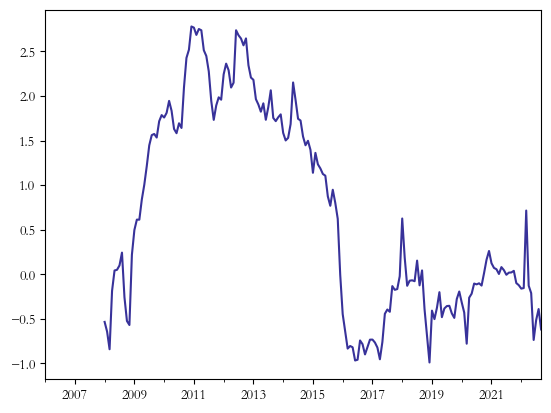

In [12]:
sharpe['rolling_sharpe_ann'].plot()